## imports

In [1]:
from rnog_data.runtable import RunTable
rnog_table = RunTable()
rnog_table.get_table()
rnog_table.get_table(stations=[12], start_time="2025-09-08 18:00:00", stop_time="2025-09-09 22:00:00")

INFO:runtable_database:database connection to RNOG_live established


,_id,station,run,time_start,time_end,duration,transfer_subsampling,trigger_rate,n_events_recorded,n_events_transferred,trigger_rf0_enabled,trigger_rf1_enabled,trigger_ext_enabled,trigger_pps_enabled,trigger_soft_enabled,soft_trigger_rate,daq_config_comment,path,firmware_version,run_type
0,68d3ab3bb463728d89823c57,12,250523,2025-09-08 17:41:24.653,2025-09-08 19:41:26.162,7201.51,0.01,4.80,34540,418,True,True,True,False,True,0.1,None,station12/run250523/combined.root,0.3.3,physics
1,68d3ab3bb463728d89823c58,12,250524,2025-09-08 19:42:51.657,2025-09-08 21:26:48.236,6236.58,0.01,12.38,77226,946,True,True,True,False,True,0.1,None,station12/run250524/combined.root,0.3.3,physics
2,68d3ab3cb463728d89823c59,12,250525,2025-09-09 00:53:08.702,2025-09-09 02:53:08.177,7199.47,0.01,1.20,8667,107,True,True,True,False,True,0.1,None,station12/run250525/combined.root,0.3.3,physics
3,68d3ab3cb463728d89823c5a,12,250526,2025-09-09 02:53:24.070,2025-09-09 04:53:24.891,7200.82,0.01,1.19,8569,100,True,True,True,False,True,0.1,None,station12/run250526/combined.root,0.3.3,physics
4,68d3ab3cb463728d89823c5b,12,250527,2025-09-09 04:53:40.453,2025-09-09 06:53:40.683,7200.23,0.01,1.20,8626,116,True,True,True,False,True,0.1,None,station12/run250527/combined.root,0.3.3,physics
5,68d3ab3cb463728d89823c5c,12,250528,2025-09-09 06:54:48.906,2025-09-09 08:54:48.677,7199.77,0.01,1.18,8515,101,True,True,True,False,True,0.1,None,station12/run250528/combined.root,0.3.3,physics
6,68d3ab3cb463728d89823c5d,12,250529,2025-09-09 08:55:05.613,2025-09-09 10:55:05.177,7199.56,0.02,1.17,8391,126,True,True,True,False,True,0.1,None,station12/run250529/combined.root,0.3.3,physics
7,68d3ab3cb463728d89823c5e,12,250530,2025-09-09 10:55:21.916,2025-09-09 12:55:21.697,7199.78,0.01,1.17,8448,107,True,True,True,False,True,0.1,None,station12/run250530/combined.root,0.3.3,physics
8,68d3ab3cb463728d89823c5f,12,250531,2025-09-09 12:55:37.605,2025-09-09 14:55:37.677,7200.07,0.01,1.22,8802,90,True,True,True,False,True,0.1,None,station12/run250531/combined.root,0.3.3,physics
9,68d3ab3db463728d89823c60,12,250532,2025-09-09 14:57:23.630,2025-09-09 16:57:23.710,7200.08,0.01,1.26,9075,131,True,True,True,False,True,0.1,None,station12/run250532/combined.root,0.3.3,physics


In [37]:
# to read any rno-g data root file and plot waveforms and extract analysis variables such as snr
import sys, os, subprocess
from datetime import datetime, timezone
import matplotlib.cm as cm
sys.path.append(os.path.abspath('/data/user/sanyukta/rno_code'))
from reading.data_reading import *
from functions.functions import *
# supress warnings
import warnings
warnings.filterwarnings("ignore")
mattak_kwargs = {
    "backend" : "uproot",
    # "backend" : "pyroot"
}

In [38]:
# constants
pa_chs = [0,1,2,3]
hpols = [8,4]
uvs = [5,6,7]
deep_chs = np.concatenate((pa_chs,hpols,uvs))
up_lpdas = [13,16,19]
down_lpdas = [12,14,15,17,18,20]
lpdas = np.concatenate((up_lpdas,down_lpdas))
lpdas.sort()

data_path = '/data/user/sanyukta/rno_data/highwind/0908'
files = [f for f in os.listdir(data_path) if f.endswith('.root')]
files.sort()
files

['station12_run250522_combined.root',
 'station12_run250523_combined.root',
 'station12_run250524_combined.root']

## reading root

In [39]:
run_types = ["physics"]
max_trigger_rate = 0  # in Hz, 0 means no cut on trigger rate
selectors = [lambda event_info : event_info.triggerType != "FORCE"] #remove forced trigger events

events = {}; times = {}; volts = {}; eve_times = {}
i = 0
for f in files:
    input_dir = os.path.join(data_path, f)
    print(f'Processing file: {input_dir}')
    reader = basic_read_root(input_dir, mattak_kwargs=mattak_kwargs, selectors=selectors)
    events[f[13:-14]], times[f[13:-14]], volts[f[13:-14]] = get_eventsvoltstraces(reader)
    eve_times[f[13:-14]] = get_event_info(reader)

Processing file: /data/user/sanyukta/rno_data/highwind/0908/station12_run250522_combined.root

 reading /data/user/sanyukta/rno_data/highwind/0908/station12_run250522_combined.root ......


WARNING - 2025-10-24 10:50:45,878 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>60% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:46,455 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>120% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:46,746 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>180% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:46,846 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>160% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:47,234 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>245% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:47,339 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>52% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:47,729 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offse

Processing file: /data/user/sanyukta/rno_data/highwind/0908/station12_run250523_combined.root

 reading /data/user/sanyukta/rno_data/highwind/0908/station12_run250523_combined.root ......


WARNING - 2025-10-24 10:50:55,193 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>118% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:55,387 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>188% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:55,667 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>145% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:55,860 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>110% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:56,054 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>148% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:56,153 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>138% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:50:56,253 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block off

Processing file: /data/user/sanyukta/rno_data/highwind/0908/station12_run250524_combined.root

 reading /data/user/sanyukta/rno_data/highwind/0908/station12_run250524_combined.root ......


WARNING - 2025-10-24 10:51:36,543 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>139% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:36,648 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>58% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:36,750 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>59% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:36,855 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>63% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:37,921 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>57% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:38,119 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>61% of Vrms), removing by fitting.
WARNING - 2025-10-24 10:51:38,804 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets 

## plotting waveform

In [40]:
runs = list(events.keys())
run_id = 2
trig_times = {}
for eve in eve_times[runs[run_id]].keys():
    if eve_times[runs[run_id]][eve]['eventNumber'] in events[runs[run_id]]:
        trig_times[eve_times[runs[run_id]][eve]['eventNumber']] = eve_times[runs[run_id]][eve]['triggerTime']

trig_t = np.array([trig_times[k] for k in trig_times.keys()])
trig_dates = [datetime.fromtimestamp(ts, tz=timezone.utc) for ts in trig_t]

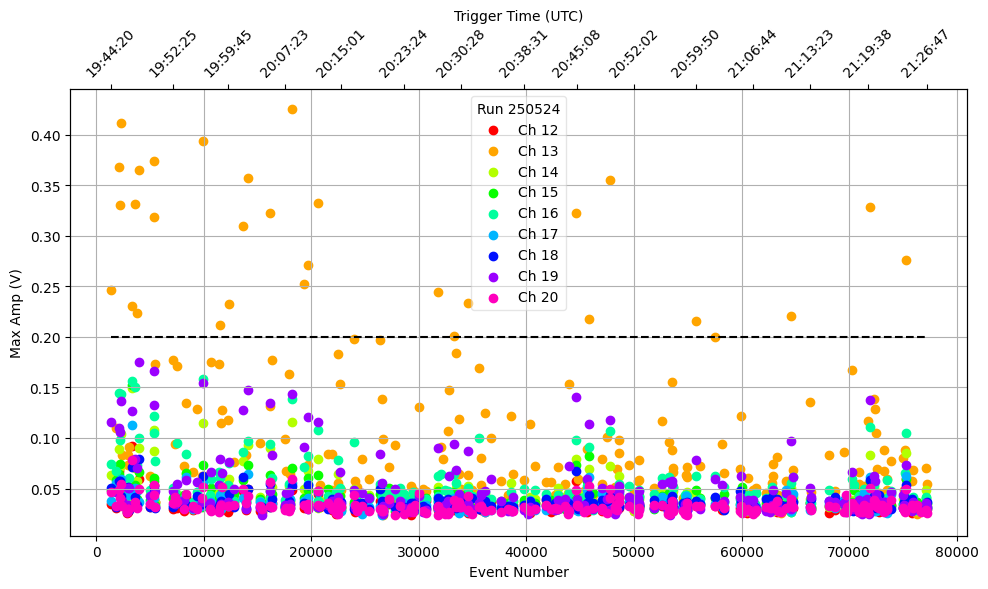

In [41]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))
colors = cm.hsv(np.linspace(0, 1, len(lpdas)+1))
for ch, color in zip(lpdas, colors):
    max_adc = [np.max(volts[runs[run_id]][eve][ch]) for eve in range(len(volts[runs[run_id]]))]
    ax1.scatter(events[runs[run_id]], max_adc, label=f'Ch {ch}', color=color)

ax1.set_xlabel('Event Number')
ax1.set_ylabel('Max Amp (V)')
ax1.legend(fancybox=True, framealpha=0.5, title=f'Run {runs[run_id]}')
ax1.grid()
# ax1.set_ylim(0,)

# Create second x-axis at the top for timestamps
ax2 = ax1.twiny()

# Set the same x-limits as the main axis
ax2.set_xlim(ax1.get_xlim())

# Create a mapping from event numbers to timestamps
event_to_time_map = {}
for i, event_num in enumerate(events[runs[run_id]]):
    event_to_time_map[event_num] = trig_dates[i]

# Set tick positions and labels for the timestamp axis
event_range = events[runs[run_id]]
min_event, max_event = min(event_range), max(event_range)

# Create more evenly distributed tick positions (increase n_ticks for more timestamps)
n_ticks = 15  # Increased number of timestamp ticks to show
tick_positions = np.linspace(min_event, max_event, n_ticks)

# Find the closest actual event numbers and their corresponding timestamps
tick_labels = []
actual_tick_positions = []

for pos in tick_positions:
    # Find the closest event number to this position
    closest_event = min(event_range, key=lambda x: abs(x - pos))
    actual_tick_positions.append(closest_event)
    
    # Get the corresponding timestamp
    timestamp_str = event_to_time_map[closest_event].strftime('%H:%M:%S')
    tick_labels.append(timestamp_str)

# Remove duplicates while preserving order
seen = set()
final_positions = []
final_labels = []
for pos, label in zip(actual_tick_positions, tick_labels):
    if pos not in seen:
        seen.add(pos)
        final_positions.append(pos)
        final_labels.append(label)

ax2.set_xticks(final_positions)
ax2.set_xticklabels(final_labels, rotation=45)
ax2.set_xlabel('Trigger Time (UTC)')
thresh = 0.2
ax1.hlines(y=thresh, xmin=events[runs[run_id]][0], xmax=events[runs[run_id]][-1], color='black', linestyle='--', label='Threshold (0.2 V)')

plt.tight_layout()
plt.show()

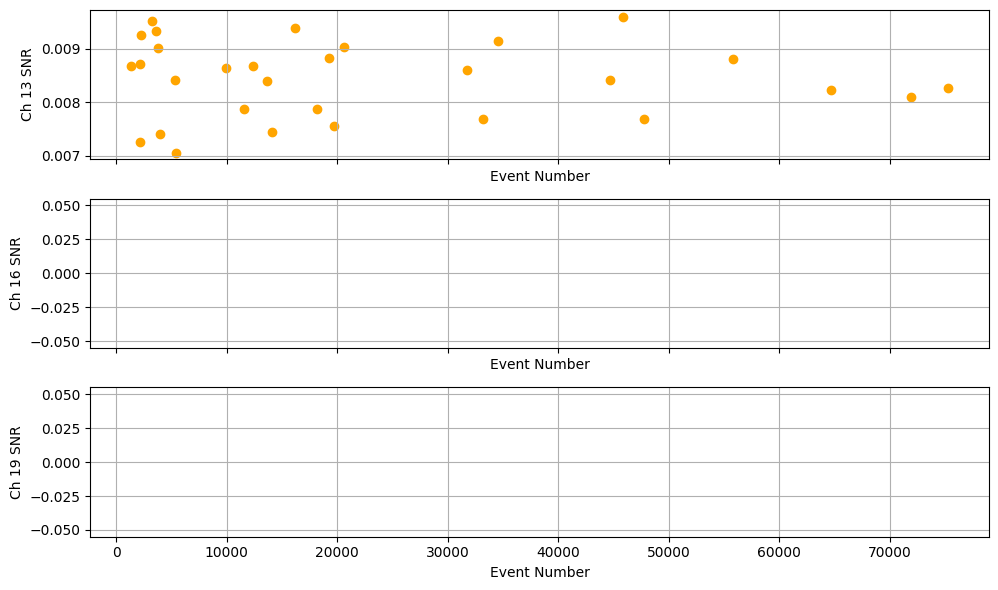

In [48]:
from NuRadioReco.utilities.fft import time2freq, freq2time, freqs
thresh = 0.2
snr = {}; noise = {}; 
for ch in lpdas:
    snr[ch] = {}; noise[ch] = {}
    max_adc = [np.max(volts[runs[run_id]][eve][ch]) for eve in range(len(volts[runs[run_id]]))]
    hw_ids = [eve_id for eve_id in range(len(events[runs[run_id]])) if np.max(volts[runs[run_id]][eve_id][ch]) > thresh]
    for id in hw_ids:
        trace = volts[runs[run_id]][id][ch]
        time = times[runs[run_id]][id][ch]
        vpk_pk = (np.max(trace) - np.min(trace))*0.5
        noise[ch][id] = np.sqrt(np.mean(trace[:200]**2))
        snr[ch][id] = vpk_pk / noise[ch][id]

fig,ax = plt.subplots(3,1, figsize=(10,6), sharex=True)
for i, ch in enumerate([13, 16, 19]):
    eve_nums = [events[runs[run_id]][id] for id in snr[ch].keys()]
    # ax[i].plot(eve_nums, list(snr[ch].values()), label=f'SNR', ls='--', color='grey')
    # ax[i].scatter(eve_nums, list(snr[ch].values()), label=f'SNR', color='blue')
    ax[i].scatter(eve_nums, list(noise[ch].values()), label=f'Noise', color='orange')
    # ax[i].set_xlim(7000,)
    ax[i].set_xlabel('Event Number')
    ax[i].set_ylabel(f'Ch {ch} SNR')
    ax[i].grid()
plt.tight_layout()
# plot the corresponding timestamps on top x-axis in ax[0]
# ax2 = ax[0].twiny()
# ax2.set_xlim(ax[0].get_xlim())


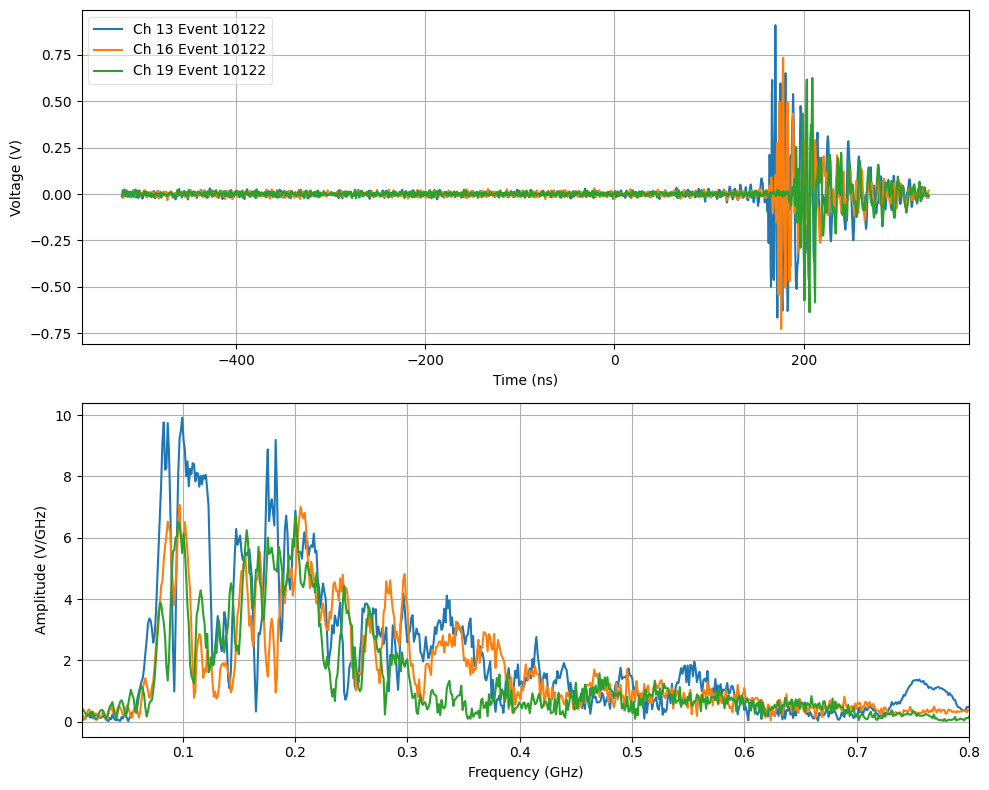

In [ ]:
# event_num = np.uint32(10122)
fig, ax = plt.subplots(2,1, figsize=(10, 8))
# pos = np.where(events[runs[run_id]]==event_num)
for chs in [13]:
    for eve_id in snr[chs].keys():
        ax[0].plot(times[runs[run_id]][eve_id][chs], volts[runs[run_id]][eve_id][chs],
                label=f'Ch {chs} Event {events[runs[run_id]][eve_id]}')
        ax[1].plot(freqs(len(times[runs[run_id]][eve_id][chs]),2.4*units.GHz), np.abs(time2freq(volts[runs[run_id]][eve_id][chs], 2.4*units.GHz)),
                label=f'Ch {chs} Event {events[runs[run_id]][eve_id]} freq')
ax[0].legend(ncols=1, fancybox=True, framealpha=0.5)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_xlim(0.01,0.8)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Amplitude (V/GHz)')
plt.tight_layout()

## wnid speed

In [2]:
from get_summit_weather_data.weather_reader import WeatherData
wd = WeatherData(years=[2024,2025], use_official=True, use_unofficial=True)
wd.getWindSpeed('2025-09-24 22:00')

np.float64(3.9)

## Pulser drops

In [6]:
in_dir = f'/data/user/sanyukta/rno_data/pulser_drops'
station_id = 14
sampling_rate = 2.4 * units.GHz
runs = [f for f in os.listdir(f'{in_dir}/st{station_id}') if f.endswith('.root')]

for run in runs:
    print(f'Processing run: {run}')
    input_dir = f'/data/user/sanyukta/rno_data/pulser_drops/st{station_id}/{run}'
    # reader = basic_read_root(input_dir, selectors=selector, sampling_rate=sampling_rate)
    # id = 0
    # for id,event in enumerate(reader.run()):
    #     id = id+ 1
    # print(f'Number of events in run {run}: {id}')
    events, times, volts = get_eventsvoltstraces(basic_read_root(input_dir, sampling_rate=sampling_rate), band_pass=1, pulse_filter=0, glitch_filter=0, cable_delay=0)
    cpevents, cptimes, cpvolts = get_eventsvoltstraces(basic_read_root(input_dir, selectors=selector, sampling_rate=sampling_rate), band_pass=1, pulse_filter=0, glitch_filter=0)
    print(f'Run: {run}, Number of events: {len(events)}, Number of cal-pulser events: {len(cpevents)}')

Processing run: station14_run500026_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500026_combined.root ......


WARNING - 2025-09-09 15:18:55,959 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>52% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:55,990 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>145% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:56,015 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>89% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:56,075 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>58% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500026_combined.root ......
Run: station14_run500026_combined.root, Number of events: 57, Number of cal-pulser events: 9
Processing run: station14_run500006_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500006_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500006_combined.root ......


WARNING - 2025-09-09 15:18:56,791 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>51% of Vrms), removing by fitting.


Run: station14_run500006_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500019_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500019_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500019_combined.root ......


WARNING - 2025-09-09 15:18:56,873 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>51% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,023 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>188% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,035 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>125% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,047 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>106% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,059 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>89% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,071 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>125% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,082 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offse

Run: station14_run500019_combined.root, Number of events: 2, Number of cal-pulser events: 1
Processing run: station14_run500025_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500025_combined.root ......


WARNING - 2025-09-09 15:18:57,094 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>67% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,106 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>101% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,118 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>110% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,136 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>74% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,286 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>188% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,298 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>106% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:57,310 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offse


 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500025_combined.root ......
Run: station14_run500025_combined.root, Number of events: 16, Number of cal-pulser events: 5
Processing run: station14_run500001_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500001_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500001_combined.root ......
Run: station14_run500001_combined.root, Number of events: 3, Number of cal-pulser events: 0
Processing run: station14_run500000_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500000_combined.root ......


WARNING - 2025-09-09 15:18:57,729 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>175% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500000_combined.root ......
Run: station14_run500000_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500013_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500013_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500013_combined.root ......
Run: station14_run500013_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500005_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500005_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500005_combined.root ......
Run: station14_run500005_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500002_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500002_combine

WARNING - 2025-09-09 15:18:58,577 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>75% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500002_combined.root ......
Run: station14_run500002_combined.root, Number of events: 5, Number of cal-pulser events: 0
Processing run: station14_run500017_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500017_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500017_combined.root ......
Run: station14_run500017_combined.root, Number of events: 2, Number of cal-pulser events: 1
Processing run: station14_run500020_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500020_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500020_combined.root ......


WARNING - 2025-09-09 15:18:59,228 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>58% of Vrms), removing by fitting.


Run: station14_run500020_combined.root, Number of events: 3, Number of cal-pulser events: 1
Processing run: station14_run500018_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500018_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500018_combined.root ......
Run: station14_run500018_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500010_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500010_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500010_combined.root ......
Run: station14_run500010_combined.root, Number of events: 2, Number of cal-pulser events: 1
Processing run: station14_run500015_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500015_combined.root ......


WARNING - 2025-09-09 15:18:59,949 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>50% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:18:59,961 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>73% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500015_combined.root ......
Run: station14_run500015_combined.root, Number of events: 4, Number of cal-pulser events: 0
Processing run: station14_run500016_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500016_combined.root ......


WARNING - 2025-09-09 15:19:00,471 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>59% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,501 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>65% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,558 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>66% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,576 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>56% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,594 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>103% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,612 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>121% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:00,686 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets


 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500016_combined.root ......


WARNING - 2025-09-09 15:19:01,283 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>56% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,324 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>52% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,359 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>54% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,388 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>68% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,581 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>88% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,593 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>66% of Vrms), removing by fitting.


Run: station14_run500016_combined.root, Number of events: 71, Number of cal-pulser events: 24
Processing run: station14_run500021_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500021_combined.root ......


WARNING - 2025-09-09 15:19:01,634 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>96% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,747 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>66% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:01,765 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>96% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500021_combined.root ......
Run: station14_run500021_combined.root, Number of events: 10, Number of cal-pulser events: 3
Processing run: station14_run500008_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500008_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500008_combined.root ......
Run: station14_run500008_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500011_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500011_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500011_combined.root ......
Run: station14_run500011_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500004_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500004_combin

WARNING - 2025-09-09 15:19:02,520 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>56% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:02,690 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>100% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500004_combined.root ......
Run: station14_run500004_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500014_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500014_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500014_combined.root ......
Run: station14_run500014_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500024_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500024_combined.root ......


WARNING - 2025-09-09 15:19:03,126 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>102% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,139 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>131% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,237 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>77% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,260 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>57% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,273 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>60% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,355 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>111% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,538 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offset


 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500024_combined.root ......


WARNING - 2025-09-09 15:19:03,586 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>77% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,604 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>57% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:03,617 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>60% of Vrms), removing by fitting.


Run: station14_run500024_combined.root, Number of events: 36, Number of cal-pulser events: 15
Processing run: station14_run500007_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500007_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500007_combined.root ......
Run: station14_run500007_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500009_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500009_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500009_combined.root ......
Run: station14_run500009_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500023_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500023_combined.root ......


WARNING - 2025-09-09 15:19:04,355 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>64% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,436 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>72% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,448 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>69% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,460 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>76% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,472 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>126% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,484 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>152% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:04,496 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets


 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500023_combined.root ......
Run: station14_run500023_combined.root, Number of events: 68, Number of cal-pulser events: 0
Processing run: station14_run500012_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500012_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500012_combined.root ......
Run: station14_run500012_combined.root, Number of events: 2, Number of cal-pulser events: 1
Processing run: station14_run500003_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500003_combined.root ......

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500003_combined.root ......
Run: station14_run500003_combined.root, Number of events: 1, Number of cal-pulser events: 0
Processing run: station14_run500022_combined.root

 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500022_combin

WARNING - 2025-09-09 15:19:06,182 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>71% of Vrms), removing by fitting.
WARNING - 2025-09-09 15:19:06,194 - NuRadioReco.RNO_G.channelBlockOffsetFitter - Trace has large block offsets (>72% of Vrms), removing by fitting.



 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500022_combined.root ......
Run: station14_run500022_combined.root, Number of events: 6, Number of cal-pulser events: 1


In [13]:
run_num = 26
station_id = 14
sampling_rate = 2.4 * units.GHz
input_dir = f'/data/user/sanyukta/rno_data/pulser_drops/st{station_id}/station14_run5000{run_num}_combined.root'
cpevents, cptimes, cpvolts = get_eventsvoltstraces(basic_read_root(input_dir, selectors=selector, sampling_rate=sampling_rate), band_pass=1, pulse_filter=0, glitch_filter=0)
len(cpevents)


 reading /data/user/sanyukta/rno_data/pulser_drops/st14/station14_run500026_combined.root ......


9

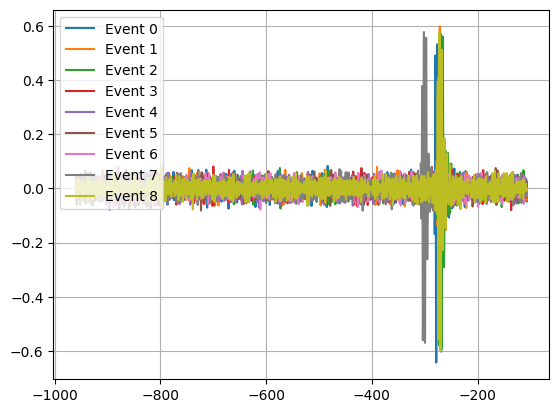

In [20]:
avg_volt = align_and_average_voltage_traces(cpvolts[0:8][7])
for eve in range(len(cpevents)):
    plt.plot(cptimes[eve][7], cpvolts[eve][7], label=f'Event {eve}')
plt.legend(loc='upper left')
plt.grid()